In [1]:
import skimage
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import numpy as np
import itertools
import torchvision
import PIL


%matplotlib inline

In [2]:
video_path = "/data/aicity/train/2.mp4"

In [3]:
def load_video(filename):
    # Loads a video with opencv, returns PIL Images for each frame
    
    vid = cv.VideoCapture(filename)

    while vid.isOpened():
        has_frame, img = vid.read()

        if has_frame:
            yield PIL.Image.fromarray(img[:,:,::-1])
        else:
            break

In [24]:
vid = load_video(video_path)

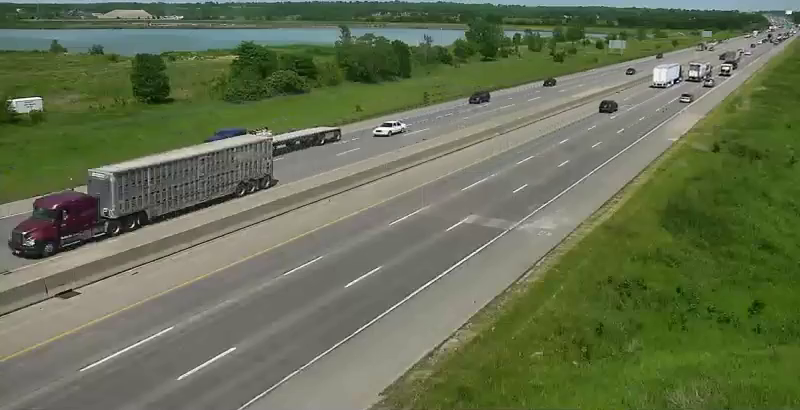

In [25]:
lq_img = next(vid)
lq_img

In [4]:
def transform_shrink_pad(img_shape, new_shape):
    """
    Resizes an image to fit in new_shape, preserving aspect ratio.
    Pads the rest (bottom or right) with 0s.
    
    """
    
    img_shape = np.array(img_shape)
    new_shape = np.array(new_shape)
    
    scale = (img_shape / new_shape).max() # Find which axis to scale by
    
    actual_new_shape = (img_shape / scale).astype(int)
    padding = new_shape - actual_new_shape
    
#     print(img_shape, new_shape, scale, actual_new_shape, padding)
    
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(actual_new_shape[::-1]),
        torchvision.transforms.Pad((0, 0, *padding))
    ])

def get_scale_factors(img_shape, new_shape):
    scales = img_shape / new_shape
    actual_new_shape = (img_shape / scales.max()).astype(int)
    padding = new_shape - actual_new_shape
    
    return scales, actual_new_shape, padding

def transform_unpad_grow(original_shape, shrunk_shape, scales, actual_new_shape, padding):
    return torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda img: img[:actual_new_shape[0], :actual_new_shape[1],]),# crop off padding
        torchvision.transforms.Resize(original_shape)
    ])

In [5]:
class VideoDataset(torch.utils.data.Dataset):
    """ Any .mp4 video should work """
    
    def __init__(self, video_filename, transform=None):
        self.video_filename = video_filename
        self.transform = transform
        
        # Open video
        self.cap = cv.VideoCapture(video_filename)
        
        # Length of video
        self.nframes = int(self.cap.get(cv.CAP_PROP_FRAME_COUNT))
        
    def __len__(self):
        return self.nframes
        
    def __getitem__(self, idx):
        """ Reads a frame, returning a PIL Image """
        
        # Make sure the index is valid
        if not (0 <= idx < self.nframes):
            raise IndexError(f"Index out of bounds: {idx} not in [0, {self.nframes})")
        
        
        self.cap.set(cv.CAP_PROP_POS_FRAMES, idx) # set position in video
        
        _, frame = self.cap.read()
        img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        img = PIL.Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
        
        return img, idx

class VideoDatasetTensor(VideoDataset):
    """ Wrapper for VideoDataset. Returns images as tensors """
    
    
    def __init__(self, video_filename, transform=None):
        super().__init__(video_filename, transform)
        
    def __getitem__(self, idx):
        img, idx = super().__getitem__(idx)
        return torchvision.transforms.ToTensor()(img), idx
        

In [6]:
vid_dataset = VideoDatasetTensor(video_path)
vid_data_loader = torch.utils.data.DataLoader(vid_dataset, shuffle=False,  batch_size=1, num_workers=0)

---
# Model Stuff

In [48]:
import sys
sys.path.append("/data/modules/")
sys.path.append("/data/modules/BasicSR/codes/")
sys.path = list(set(sys.path))

import BasicSR
from BasicSR.codes.models.SR_model import SRModel
import options.options as options
import utils.util as util

In [45]:
opt_path = "/data/modules/BasicSR/codes/options/test/test_SRResNet2.yml"

In [46]:
opt = options.parse(opt_path, is_train=False)
opt["dist"] = False
opt["train"] = None
opt["path"]["strict_load"] = True
opt

export CUDA_VISIBLE_DEVICES=0


OrderedDict([('name', 'MSRGANx4'),
             ('suffix', None),
             ('model', 'sr'),
             ('distortion', 'sr'),
             ('scale', 4),
             ('crop_border', None),
             ('gpu_ids', [0]),
             ('datasets',
              OrderedDict([('test_1',
                            OrderedDict([('name', 'aicity'),
                                         ('mode', 'test'),
                                         ('dataroot_GT', None),
                                         ('dataroot_LQ',
                                          '/data/aicity/train/2.mp4'),
                                         ('phase', 'test'),
                                         ('scale', 4),
                                         ('data_type', 'img')]))])),
             ('network_G',
              OrderedDict([('which_model_G', 'MSRResNet'),
                           ('in_nc', 3),
                           ('out_nc', 3),
                           ('nf', 64),
       

In [10]:
sr_model = SRModel(opt)

In [11]:
for data, idx in vid_data_loader:
    sr_model.feed_data({"LQ": data}, need_GT=False)
    break

In [12]:
sr_model.test()

In [18]:
res = sr_model.get_current_visuals(need_GT=False)
img = util.tensor2img(res["SR"])

In [26]:
sr_img = PIL.Image.fromarray(img[:, :, ::-1])

In [28]:
lq_img.size

(800, 410)

In [29]:
sr_img.size

(3200, 1640)

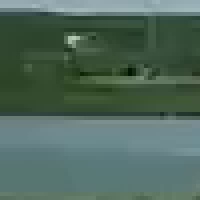

In [36]:
lq_img.crop((0, 0, 50, 50)).resize((200, 200))

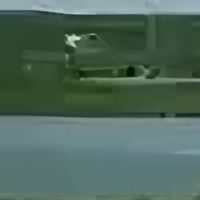

In [33]:
sr_img.crop((0, 0, 200, 200))

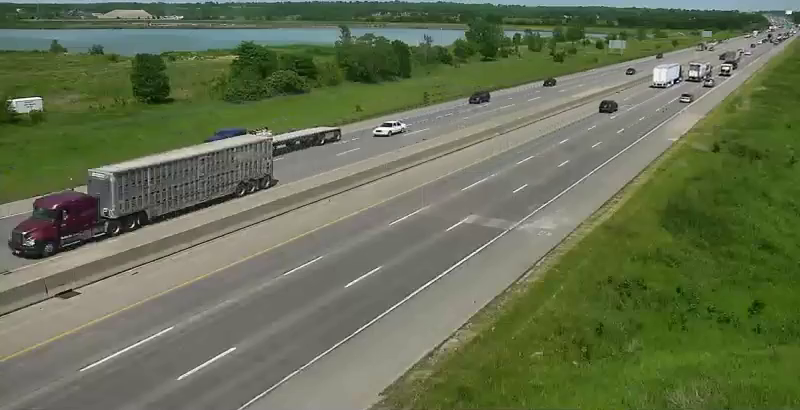

In [44]:
lq_img

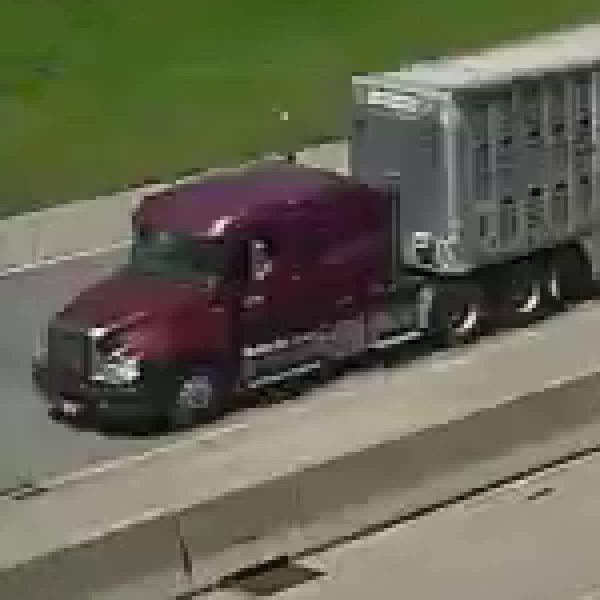

In [41]:
lq_img.crop((0, 150, 150, 300)).resize((600, 600))

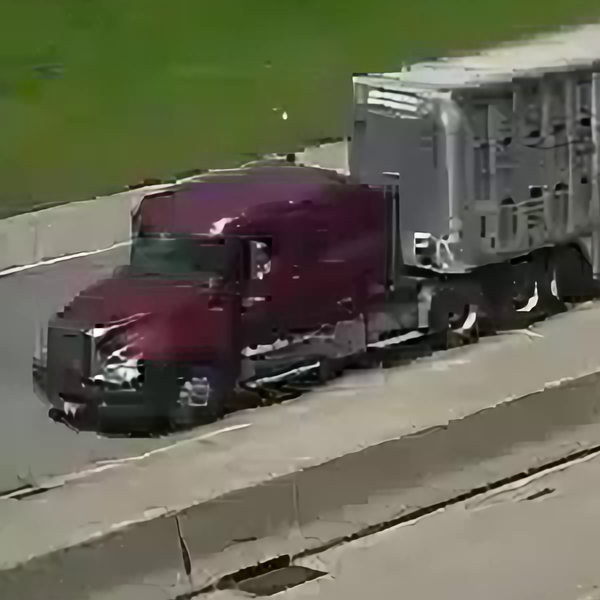

In [42]:
sr_img.crop((0, 600, 600, 1200))

---
# SRGAN Model

In [50]:
from BasicSR.codes.models.SRGAN_model import SRGANModel

In [51]:
opt_path = "/data/modules/BasicSR/codes/options/test/test_SRGAN2.yml"

In [54]:
opt = options.parse(opt_path, is_train=False)
opt["dist"] = False
opt["train"] = None
opt["path"]["strict_load"] = True
opt["path"]["pretrain_model_D"] = None
opt

export CUDA_VISIBLE_DEVICES=0


OrderedDict([('name', 'MSRGANx4'),
             ('suffix', None),
             ('model', 'sr'),
             ('distortion', 'sr'),
             ('scale', 4),
             ('crop_border', None),
             ('gpu_ids', [0]),
             ('datasets',
              OrderedDict([('test_1',
                            OrderedDict([('name', 'aicity'),
                                         ('mode', 'test'),
                                         ('dataroot_GT', None),
                                         ('dataroot_LQ',
                                          '/data/aicity/train/2.mp4'),
                                         ('phase', 'test'),
                                         ('scale', 4),
                                         ('data_type', 'img')]))])),
             ('network_G',
              OrderedDict([('which_model_G', 'MSRResNet'),
                           ('in_nc', 3),
                           ('out_nc', 3),
                           ('nf', 64),
       

In [55]:
srgan_model = SRGANModel(opt)

In [57]:
for data, idx in vid_data_loader:
    srgan_model.feed_data({"LQ": data}, need_GT=False)
    break

In [58]:
srgan_model.test()

In [59]:
res = srgan_model.get_current_visuals(need_GT=False)
img = util.tensor2img(res["SR"])

In [60]:
sr_img = PIL.Image.fromarray(img[:, :, ::-1])

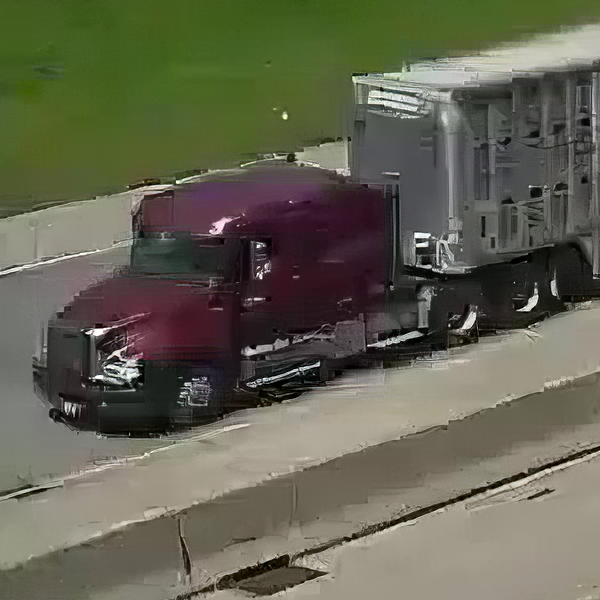

In [64]:
sr_img.crop((0, 600, 600, 1200))

---
# ESRGAN Model

In [65]:
from models.modules.RRDBNet_arch import RRDBNet

In [67]:
def create_ESRGAN(opt):
    model_opt = opt["network_G"]
    rrdb = RRDBNet(model_opt["in_nc"], model_opt["out_nc"], model_opt["nf"], model_opt["nb"])
    rrdb.load_state_dict(torch.load(opt["path"]["pretrain_model_G"]), strict=True)
    rrdb = rrdb.to(torch.device('cuda'))
    
    return rrdb

In [68]:
opt_path = "/data/modules/BasicSR/codes/options/test/test_ESRGAN2.yml"

In [69]:
opt = options.parse(opt_path, is_train=False)
opt["dist"] = False
opt["train"] = None
opt["path"]["strict_load"] = True
opt["path"]["pretrain_model_D"] = None
opt

export CUDA_VISIBLE_DEVICES=0


OrderedDict([('name', 'RRDB_ESRGAN_x4'),
             ('suffix', None),
             ('model', 'sr'),
             ('distortion', 'sr'),
             ('scale', 4),
             ('crop_border', None),
             ('gpu_ids', [0]),
             ('datasets',
              OrderedDict([('test_1',
                            OrderedDict([('name', 'aicity'),
                                         ('mode', 'test'),
                                         ('dataroot_GT', None),
                                         ('dataroot_LQ',
                                          '/data/aicity/train/2.mp4'),
                                         ('phase', 'test'),
                                         ('scale', 4),
                                         ('data_type', 'img')]))])),
             ('network_G',
              OrderedDict([('which_model_G', 'RRDBNet'),
                           ('in_nc', 3),
                           ('out_nc', 3),
                           ('nf', 64),
   

In [70]:
esrgan_model = create_ESRGAN(opt)

In [72]:
with torch.no_grad():
    for data, idx in vid_data_loader:
        res = esrgan_model(data.to(torch.device('cuda')))
        break

In [76]:
img = util.tensor2img(res)
sr_img = PIL.Image.fromarray(img[:, :, ::-1])

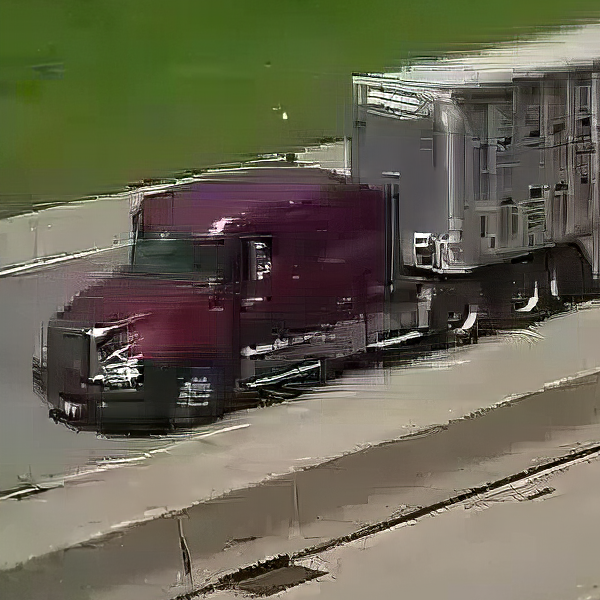

In [78]:
sr_img.crop((0, 600, 600, 1200))

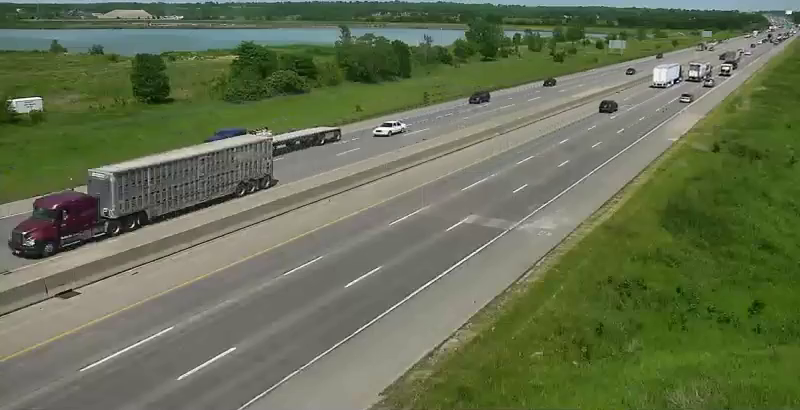

In [81]:
lq_img

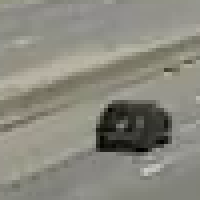

In [86]:
lq_img.crop((575, 75, 625, 125)).resize((200, 200))

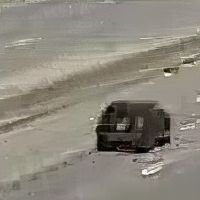

In [88]:
sr_img.crop((575*4, 75*4, 625*4, 125*4))